<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/BulkAnalyze_comparescoringtechniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import scipy

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GCP_data
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

/content/drive/MyDrive/GCP_data
--2023-11-04 03:17:27--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  1.17MB/s    in 0.2s    

2023-11-04 03:17:27 (1.17 MB/s) - ‘pred_formal.html’ saved [189067]



In [54]:
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import os

#parse the html
soup = BeautifulSoup(open("/content/drive/MyDrive/GCP_data/pred_formal.html").read())

#the 'recipe' and 'statistic' columns don't always get parsed correctly due
# to the break, but we can work around it
rows = [[td.contents[0].rstrip() for td in row.find_all("td") ]
        for row in soup.body.table.tbody.find_all("tr")]

#prepare the event IDs to be analyzed
included_events = []
for row in rows:
  if row[-1].startswith("Yes"): #only keep those events used in the GCP analysis (e.g. exclude events noted as redundant or post-hoc)
    event_num = row[0]
    event_name = row[1]
    start, end = row[2], row[3]
    start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    duration = 1 + (end_datetime - start_datetime).total_seconds()
    numpy_outfile = '/content/drive/MyDrive/GCP_data/extracted/Event'+event_num+"_test_eggvalues.npy"
    print(event_num, event_name, start, end)
    if (duration < 60):
      print("********Skipping because too short: ",event_num, event_name, start, end, duration)
      continue
    if (duration > 36*60*60):
      print("********Skipping because too long: ",event_num, event_name, start, end, duration)
      continue
    if (os.path.exists(numpy_outfile)==False):
      print("********Skipping due to missing file: ",event_num, event_name, start, end)
      continue
    if ("New Year Var" in event_name):
      print("********Skipping because redundant with a corresponding 'mean' event: ",event_num,event_name, start, end)
      continue

    included_events.append((event_num, event_name, start, end, duration))


1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59
3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59
4 Swissair 111 Crash 1998-09-03 01:00:00 1998-09-03 03:59:59
5 McGwire Record 1998-09-09 01:00:00 1998-09-09 01:29:59
6 Clinton Grand Jury 1998-09-11 19:00:00 1998-09-11 22:59:59
7 Casitas Collapse 1998-10-30 15:30:00 1998-10-30 15:59:59
8 Casitas Flood 1998-10-30 19:00:00 1998-10-30 21:59:59
9 Global Vigil JT 1998-11-13 16:00:00 1998-11-13 16:14:59
11 World Peace UN 1998-12-10 23:30:00 1998-12-11 00:29:59
12 Iraq Bombing 1998-12-16 21:30:00 1998-12-16 22:29:59
13 Vote Impeachment 1998-12-19 17:00:00 1998-12-19 19:59:59
14 Christmas Eve UTC 1998-12-24 16:00:00 1998-12-24 17:59:59
15 Christmas Eve EST 1998-12-24 21:00:00 1998-12-24 22:59:59
16 Christmas Eve PST 1998-12-25 00:00:00 1998-12-25 01:59:59
17 New Year Mean 1998-1999 1998-12-31 09:30:00 1999-01-01 12:29:59
21 Earthquake Columbia 1999-01-25 17:15:00 1999-01-25 21:14:59
22 Clinton Acquittal 1999-02-12 17:30:00 1999-02-12 

In [61]:
def compare_different_calc_approaches(egg_values, blocksizes):
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row

  egg_zscores = (egg_values - 100)/np.sqrt(50)

  pvaltozs_sumthensquare = []
  pvaltozs_squarethensum = []
  for blocksize in blocksizes:
    num_blocks = int((len(egg_zscores) - (len(egg_zscores)%blocksize))/blocksize)
    num_eggs = egg_zscores.shape[-1]
    blockreshaped_eggzscores = egg_zscores[0 : blocksize*num_blocks].reshape(num_blocks, blocksize, num_eggs)

    perblock_peregg_zsums = np.sum(blockreshaped_eggzscores, axis=1)/np.sqrt(blocksize) #shape becomes (num_blocks x num_eggs), nan if any value in the block is nan
    num_nonnan_eggblocks = np.sum(np.isnan(perblock_peregg_zsums)==False, axis=-1) #shape is num_blocks

    #compute p value if we sum across eggs first, then square
    perblock_zsums = np.nansum(perblock_peregg_zsums, axis=1)/np.maximum(np.sqrt(num_nonnan_eggblocks), 1) #shape becomes num_blocks
    if np.sum(np.isnan(perblock_zsums)) > 0:
      assert False, np.sum(np.isnan(perblock_zsums))
    pvaltoz_sumthensquare = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(x=np.nansum(np.square(perblock_zsums)), df=np.sum(num_nonnan_eggblocks > 0)))
    pvaltozs_sumthensquare.append(pvaltoz_sumthensquare)

    #compute p value if we square first, then sum across eggs and timesteps
    pvaltoz_squarethensum = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(np.nansum(np.square(perblock_peregg_zsums)),
                                                  df=np.sum(num_nonnan_eggblocks)))
    #the above code sometimes returns cdfs of 1.0, so we will also use the normal approx and take the less significant of the two
    pvaltoz_squarethensum = min(pvaltoz_squarethensum,
                                np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )
    pvaltozs_squarethensum.append(pvaltoz_squarethensum)

  return pvaltozs_sumthensquare, pvaltozs_squarethensum

In [21]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

event_count = 0

BLOCKSIZES = [1,2,3,5, 10, 15, 20, 30, 60]

all_pvaltozs_sumthensquare = []
all_pvaltozs_squarethensum = []

for (event_num, event_name, start, end, duration) in included_events:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:", event_count, "Event"+str(event_num), event_name, start, end, duration)

  egg_values_test = np.load("extracted/Event"+event_num+"_test_eggvalues.npy")
  pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(egg_values_test, BLOCKSIZES)
  print("Sum then square:", pvaltozs_sumthensquare)
  print("Square then sum:", pvaltozs_squarethensum)

  all_pvaltozs_sumthensquare.append(pvaltozs_sumthensquare)
  all_pvaltozs_squarethensum.append(pvaltozs_squarethensum)

/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Sum then square: [1.6796770942503958, 0.4790607678511112, 0.6790005001783374, 0.988725432018365, 0.6812334745387302, 0.7977339541574902, 0.6917324870531635, 0.2337795883343774, -0.7211616029137917]
Square then sum: [1.3636899801142683, 0.44543915364945785, 0.5239696919399582, 0.319785084079908, -0.17632059010521792, 1.1338059759676669, 0.2738803062405167, 0.4640269248010259, 0.5323786694858024]

--------------------------------
Event Count: 2 Event3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59 1800.0
Sum then square: [-0.3745554539454168, -0.25270621369238366, -1.4279913428063409, 0.3687509596854434, 0.4579425711817513, 1.126964922875997, 1.0382914118480753, -0.614630292841636, -0.017598483092626373]
Square then sum: [0.09886325960324202, -0.31289871458679225, -1.4946216979932447, -0.6040866263822746, -0.7038981103039315, -0.2295252

num events: 470
Blocksize: 1 seconds
Meta-analysis Z-score if squaring *after* summing: 6.109826861890255
Meta-analysis Z-score if squaring *before* summing 5.215401408931855
Argmax event for square after summing: ('391', 'Internat Day Peace', '2011-09-21 00:00:00', '2011-09-21 23:59:59', 86400.0) 3.1348047339233664
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', '2008-08-29 02:00:00', '2008-08-29 03:59:59', 7200.0) 3.6931101876027674
Correlation between the two scores: PearsonRResult(statistic=0.09198232266739069, pvalue=0.04625640290594915)


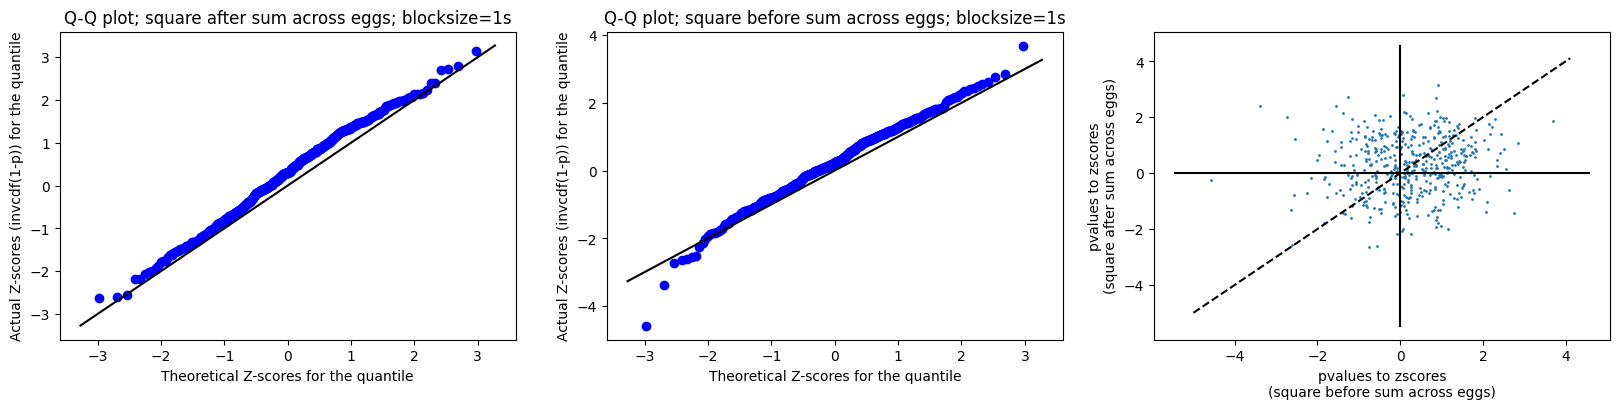

Blocksize: 2 seconds
Meta-analysis Z-score if squaring *after* summing: 3.5395375880261737
Meta-analysis Z-score if squaring *before* summing 4.327179021210653
Argmax event for square after summing: ('217', 'Indonesian Earthquake', '2006-05-26 21:54:00', '2006-05-27 05:53:59', 28800.0) 2.8536347510654143
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 4.238343284071679
Correlation between the two scores: PearsonRResult(statistic=0.16040663724996115, pvalue=0.00048139039859276914)


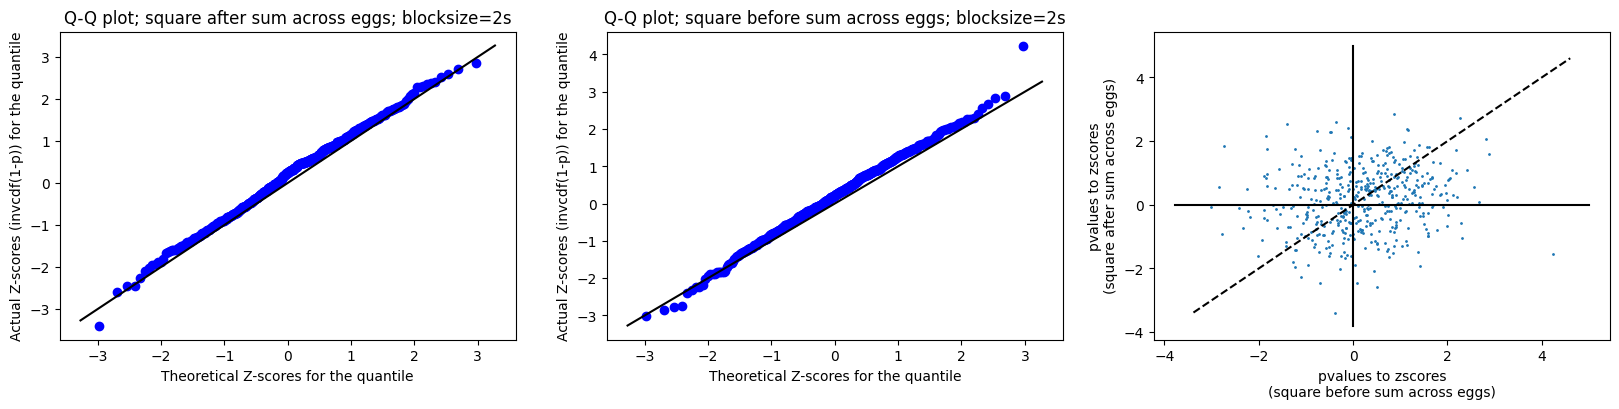

Blocksize: 3 seconds
Meta-analysis Z-score if squaring *after* summing: 2.6439137132218877
Meta-analysis Z-score if squaring *before* summing 4.717246500606658
Argmax event for square after summing: ('209', 'Jordan Bombs', '2005-11-09 18:00:00', '2005-11-09 22:59:59', 18000.0) 2.891194279937418
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 4.650509198384393
Correlation between the two scores: PearsonRResult(statistic=0.1622170478269191, pvalue=0.0004142577853861725)


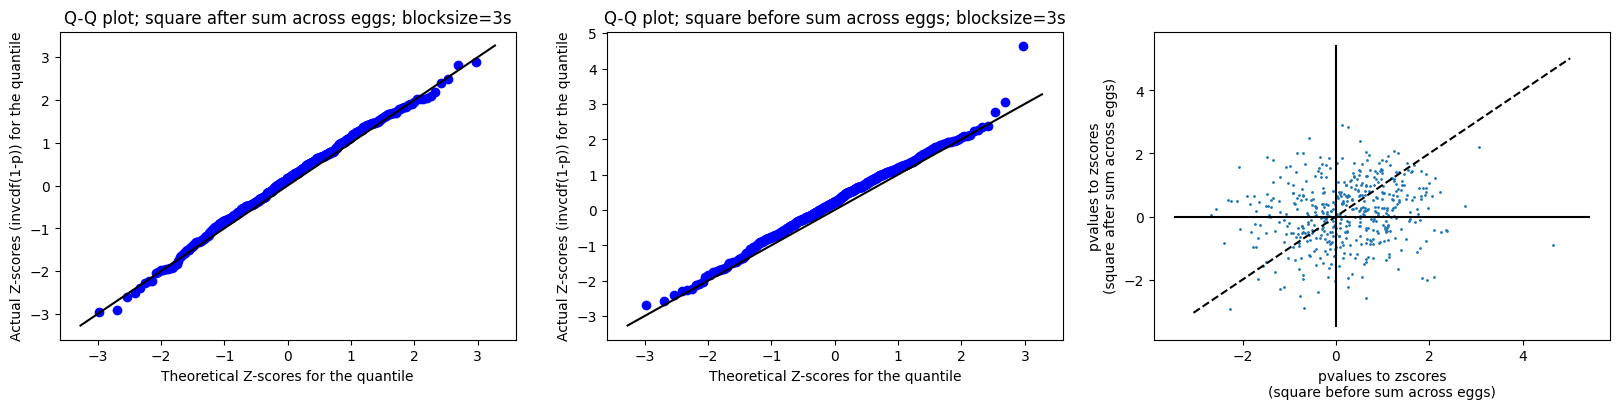

Blocksize: 5 seconds
Meta-analysis Z-score if squaring *after* summing: 2.4782427367548867
Meta-analysis Z-score if squaring *before* summing 1.8451284977542906
Argmax event for square after summing: ('67', 'Central America Quake', '2001-01-13 17:18:29', '2001-01-13 17:48:28', 1800.0) 2.843886739961646
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 6.9921785238799945
Correlation between the two scores: PearsonRResult(statistic=0.1971774541170967, pvalue=1.664850862913715e-05)


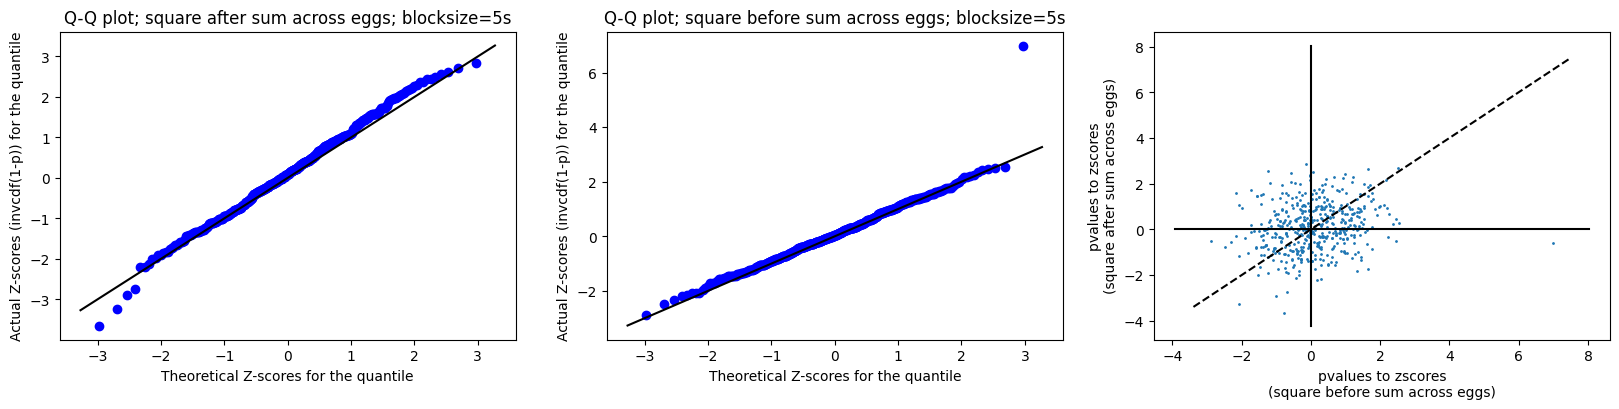

Blocksize: 10 seconds
Meta-analysis Z-score if squaring *after* summing: 1.3029380566481534
Meta-analysis Z-score if squaring *before* summing 1.9255520331210707
Argmax event for square after summing: ('90', 'World-Wide Meditations', '2001-11-11 11:00:00', '2001-11-11 11:14:59', 900.0) 3.29727774692361
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 8.458948430888265
Correlation between the two scores: PearsonRResult(statistic=0.07958246064251108, pvalue=0.08480776208393237)


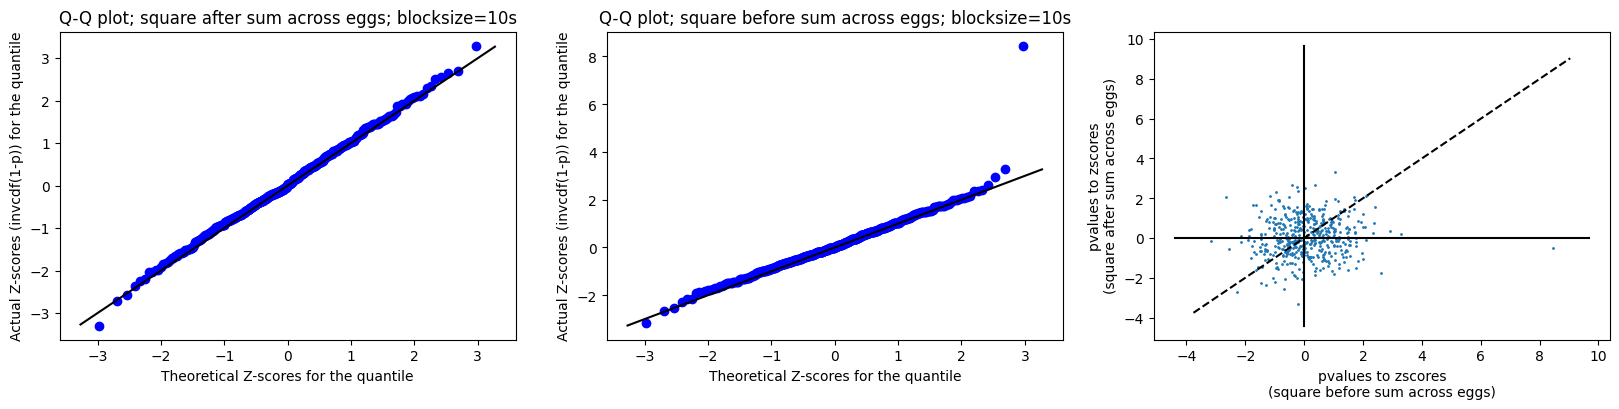

Blocksize: 15 seconds
Meta-analysis Z-score if squaring *after* summing: 0.49969888121389083
Meta-analysis Z-score if squaring *before* summing 1.9896607812298877
Argmax event for square after summing: ('90', 'World-Wide Meditations', '2001-11-11 11:00:00', '2001-11-11 11:14:59', 900.0) 2.841416405131285
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 9.896329500634886
Correlation between the two scores: PearsonRResult(statistic=0.1766241236262423, pvalue=0.00011849123897850495)


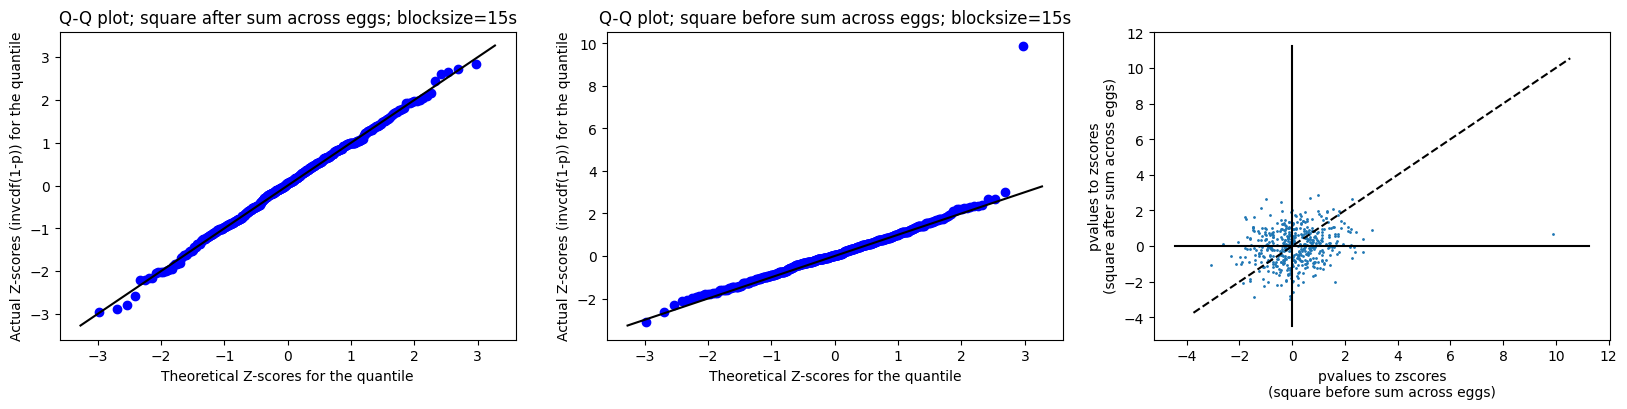

Blocksize: 20 seconds
Meta-analysis Z-score if squaring *after* summing: 0.7275201021803993
Meta-analysis Z-score if squaring *before* summing 1.7850801487492267
Argmax event for square after summing: ('506', 'Iran Nuclear Deal', '2015-07-14 10:25:00', '2015-07-14 16:24:59', 21600.0) 3.439355020322448
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 10.324797877276392
Correlation between the two scores: PearsonRResult(statistic=0.18522945084963252, pvalue=5.345159514324947e-05)


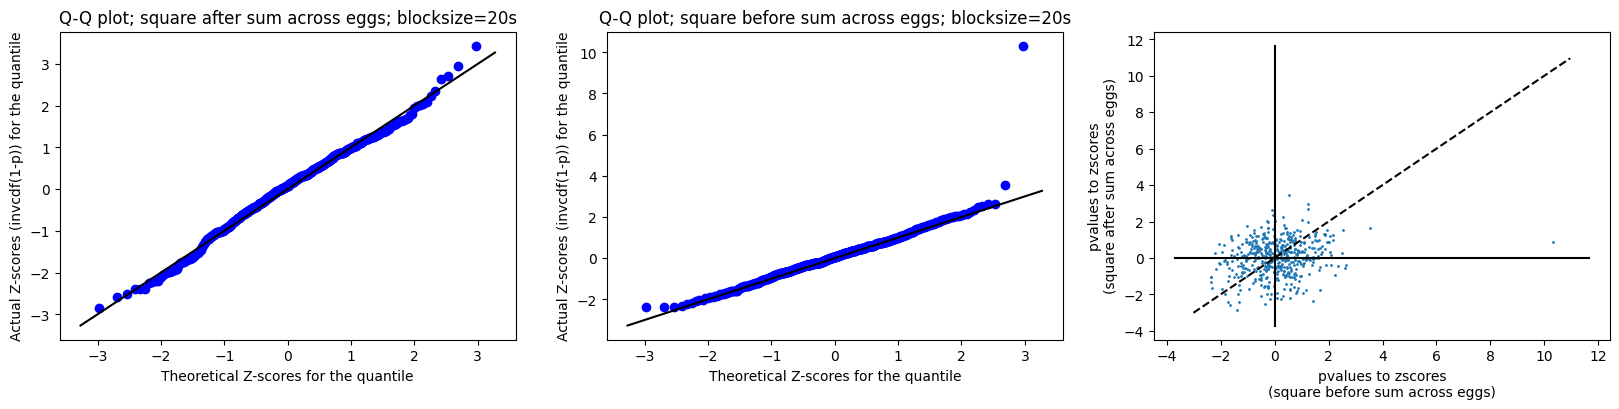

Blocksize: 30 seconds
Meta-analysis Z-score if squaring *after* summing: 0.7516648028719278
Meta-analysis Z-score if squaring *before* summing 0.1869358001908449
Argmax event for square after summing: ('90', 'World-Wide Meditations', '2001-11-11 11:00:00', '2001-11-11 11:14:59', 900.0) 3.4382621675519007
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 12.182408428909886
Correlation between the two scores: PearsonRResult(statistic=0.1674436862048378, pvalue=0.0002661462996605432)


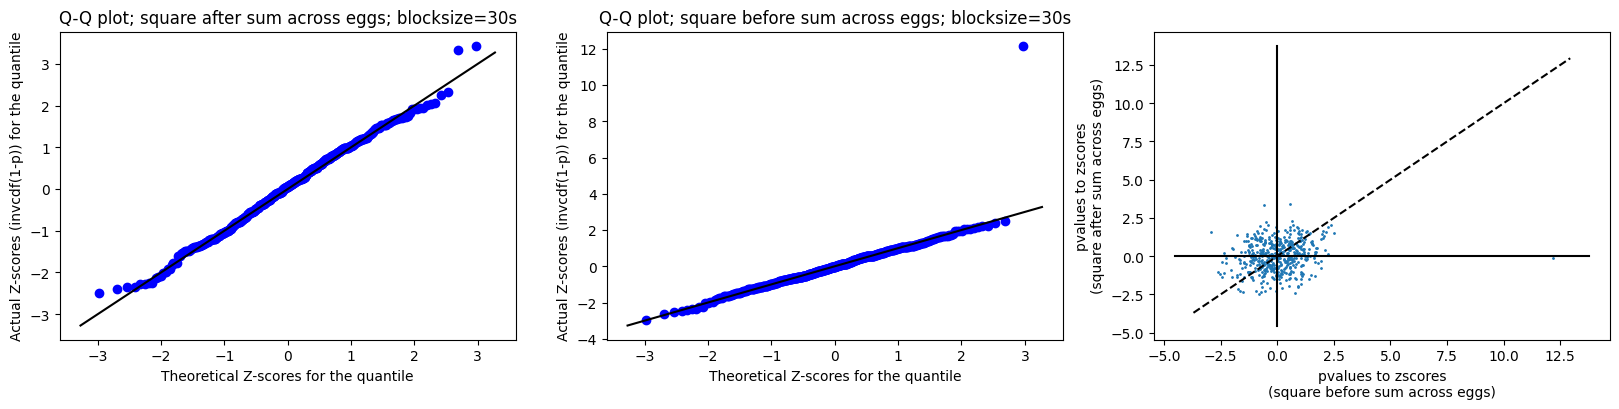

Blocksize: 60 seconds
Meta-analysis Z-score if squaring *after* summing: -0.2151391718268186
Meta-analysis Z-score if squaring *before* summing -0.35975413179709664
Argmax event for square after summing: ('119', 'Twyman in Baghdad', '2002-10-12 17:00:00', '2002-10-12 17:19:59', 1200.0) 2.9106694155625603
Argmax event for square before summing: ('200', 'Live 8 Concert', '2005-07-02 00:00:00', '2005-07-02 23:59:59', 86400.0) 10.576649499070054
Correlation between the two scores: PearsonRResult(statistic=0.13079991463107968, pvalue=0.004506610169778283)


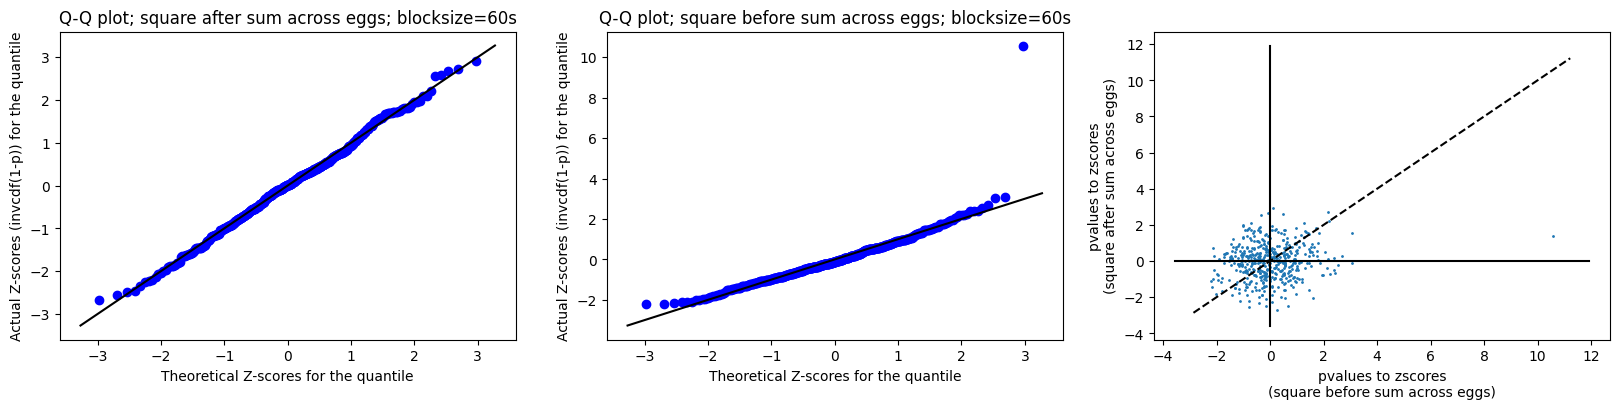

In [85]:
from matplotlib import pyplot as plt

print("num events:", len(included_events))

for blocksize_counter, blocksize in enumerate(BLOCKSIZES):
  print("Blocksize:", blocksize, "seconds")

  pvaltoz_sumthensquare = np.array([x[blocksize_counter] for x in all_pvaltozs_sumthensquare])
  pvaltoz_squarethensum = np.array([x[blocksize_counter] for x in all_pvaltozs_squarethensum])

  print("Meta-analysis Z-score if squaring *after* summing:", np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare)))
  print("Meta-analysis Z-score if squaring *before* summing", np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum)))
  print("Argmax event for square after summing:", included_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
  print("Argmax event for square before summing:", included_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
  print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

  fig, ax = plt.subplots(ncols=3, figsize=(20,4))
  plt.sca(ax[0])
  scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square after sum across eggs; blocksize="+str(blocksize)+"s")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[1])
  scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square before sum across eggs; blocksize="+str(blocksize)+"s")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[2])
  plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
  plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
  plt.plot(plt.xlim(), [0,0], color="black")
  plt.plot([0,0], plt.ylim(), color="black")
  plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
  plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
  plt.show()